In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install praw torch transformers vaderSentiment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 4.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 8.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Enter the stock name:  Tata Motors


Sentiment Scores for Tata Motors:
Positive: 0.1036
Negative: 0.3753
Neutral: 0.5212


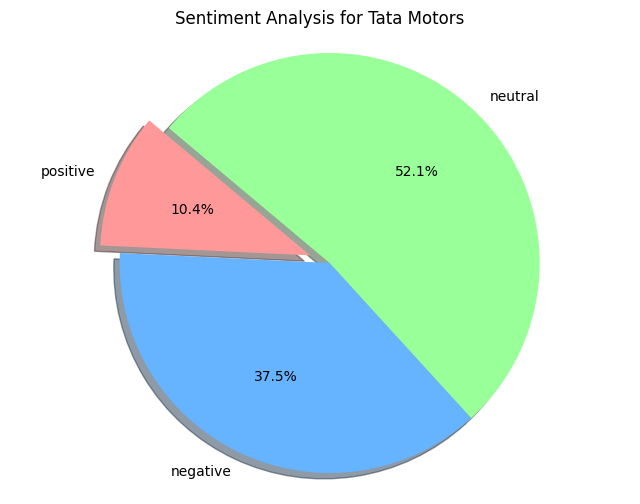

In [3]:
import praw
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Initialize Reddit API (PRAW)
reddit = praw.Reddit(
    client_id='t2bNyMB4wU0yXdeWb7nVcQ',
    client_secret='Y5iOhI76laXgItwsSFTiKfDcRNyqwQ',
    user_agent='QuantumCoders/0.1 by Ok_profession1025'
)

# Load FinBERT model and tokenizer
finbert_tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
finbert_model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')

# Initialize VADER Sentiment Analyzer
vader_analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment_finbert(text):
    """Analyze sentiment using FinBERT."""
    inputs = finbert_tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = finbert_model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    sentiment_scores = probabilities.detach().cpu().numpy()[0]  # Extracting scores

    # FinBERT labels: [0] Negative, [1] Neutral, [2] Positive
    sentiment_dict = {
        "negative": sentiment_scores[0],
        "neutral": sentiment_scores[1],
        "positive": sentiment_scores[2]
    }
    
    return sentiment_dict

def analyze_sentiment_vader(text):
    """Analyze sentiment using VADER."""
    sentiment_score = vader_analyzer.polarity_scores(text)
    sentiment_dict = {
        "negative": sentiment_score['neg'],
        "neutral": sentiment_score['neu'],
        "positive": sentiment_score['pos']
    }
    return sentiment_dict
def plot_sentiment_pie(sentiment_scores, stock_name):
    """Plot a pie chart of the sentiment scores."""
    labels = sentiment_scores.keys()
    sizes = sentiment_scores.values()
    colors = ['#ff9999','#66b3ff','#99ff99']
    explode = (0.1, 0, 0)  # explode the first slice (positive)

    plt.figure(figsize=(8, 6))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=140)
    plt.title(f'Sentiment Analysis for {stock_name}')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()
import time  # Import time module to handle timestamps

def get_sentiment(stock_name):
    """Fetch posts from Reddit and analyze sentiment for a specific stock."""
    # Aggregated sentiment results
    aggregated_sentiments = {"positive": 0, "negative": 0, "neutral": 0}
    total_posts = 0

    # Fetch posts from multiple subreddits
    subreddits = ['IndianStockMarket', 'wallstreetbets', 'investing', 'IndianStreetBets']
    
    for subreddit in subreddits:
        posts = reddit.subreddit(subreddit).search(stock_name, limit=100)
        
        for post in posts:
            text = post.title + " " + post.selftext

            # Filter out short or low-relevance posts
            if len(text.split()) < 20:
                continue

            # Analyze sentiment using VADER and FinBERT
            vader_sentiment = analyze_sentiment_vader(text)
            finbert_sentiment = analyze_sentiment_finbert(text)

            # Check the time the post was created
            post_time = post.created_utc  # UTC timestamp
            current_time = time.time()  # Current time in UTC
            time_difference = current_time - post_time  # Time difference in seconds

            # Check if the post is within the first hour of posting
            if time_difference <= 3600:  # 3600 seconds = 1 hour
                upvotes = post.ups  # Number of upvotes
                # Prioritize posts with significant upvotes
                if upvotes > 5:  # Example threshold for prioritizing
                    # Scale the sentiment scores for high-priority posts
                    vader_sentiment["positive"] *= 1.5  # Increase weight for positive sentiment
                    vader_sentiment["negative"] *= 0.5  # Decrease weight for negative sentiment
                    finbert_sentiment["positive"] *= 1.5
                    finbert_sentiment["negative"] *= 0.5

            # Combine FinBERT and VADER results by averaging them
            aggregated_sentiments["positive"] += (vader_sentiment["positive"] + finbert_sentiment["positive"]) / 2
            aggregated_sentiments["negative"] += (vader_sentiment["negative"] + finbert_sentiment["negative"]) / 2
            aggregated_sentiments["neutral"] += (vader_sentiment["neutral"] + finbert_sentiment["neutral"]) / 2

            total_posts += 1

    if total_posts > 0:
        # Normalize sentiment scores by the number of posts processed
        aggregated_sentiments = {k: v / total_posts for k, v in aggregated_sentiments.items()}

    return aggregated_sentiments


if __name__ == "__main__":
    stock_name = input("Enter the stock name: ")
    sentiment_scores = get_sentiment(stock_name)
    print(f"Sentiment Scores for {stock_name}:")
    print(f"Positive: {round(sentiment_scores['positive'], 4)}")
    print(f"Negative: {round(sentiment_scores['negative'], 4)}")
    print(f"Neutral: {round(sentiment_scores['neutral'], 4)}")

    plot_sentiment_pie(sentiment_scores, stock_name)